In [212]:
import glob
import os
import re
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

import skimage.transform
import scipy.ndimage
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data

import scipy.misc
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

data = '/mnt/luna-2016-data/'
OUTPUT_FOLDER = '/kaggle_2/luna/output_pre_process/'
candidates = '/mnt/luna-2016-data/annotations.csv'

In [204]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

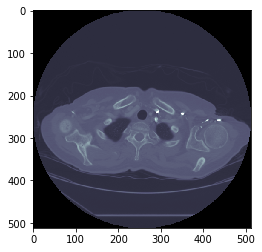

In [205]:
def plot_2d(im):
    # Show some slice in the middle
    plt.imshow(im, cmap=plt.cm.bone)
    plt.show()
    
image, origin, spacing = load_itk(impath)

# Show some slice in the middle
random_slice_index = int(np.random.random() * image.shape[0])
plot_2d(image[random_slice_index])

In [206]:
def resample(img, new_spacing=[1,1,1]):
    resize_factor = spacing / new_spacing
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize

    #resize image
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    return lung_img, new_spacing

In [158]:
pix_resampled, spacing = resample(image, [1,1,1])
print("Shape before resampling\t", image.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (117, 512, 512)
Shape after resampling	 (292, 400, 400)


In [207]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = scipy.ndimage.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im


In [208]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [209]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

In [210]:
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])

'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image.shape)

    #run over all the nodules in the lungs
    for ca in cands.values:
        #get middel x-,y-, and z-worldcoordinate of the nodule
        radius = np.ceil(ca[4])/2
        coord_x = ca[1]
        coord_y = ca[2]
        coord_z = ca[3]
        image_coord = np.array((coord_z,coord_y,coord_x))

        #determine voxel coordinate given the worldcoordinate
        image_coord = world_2_voxel(image_coord,origin,spacing)

        #determine the range of the nodule
        noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

        #create the mask
        for x in noduleRange:
            for y in noduleRange:
                for z in noduleRange:
                    coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
                    if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        image_mask[int(np.round(coords[0])),int(np.round(coords[1])),int(np.round(coords[2]))] = int(1)

    return image_mask

'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, cands):
    imageName = os.path.split(imagePath)[1].replace('.mhd','')
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize

    #resize image
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
    lung_img = lung_img + 1024
    lung_mask = segment_lung_from_ct_scan(lung_img)
    lung_img = lung_img - 1024

    image_cads = cands[cands['seriesuid'] == imageName]
    #create nodule mask
    nodule_mask = draw_circles(lung_img,image_cads,origin,new_spacing)

    lung_img_512 = np.zeros((lung_img.shape[0], 512, 512))
    lung_mask_512 = np.zeros((lung_mask.shape[0], 512, 512))
    nodule_mask_512 = np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = int(np.round(offset/2))
        lower_offset = offset - upper_offset

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)
        
        lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
        lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
    np.save(OUTPUT_FOLDER + imageName + '_lung_img.npy', lung_img_512)
    np.save(OUTPUT_FOLDER + imageName + '_lung_mask.npy', lung_mask_512)
    np.save(OUTPUT_FOLDER + imageName + '_nodule_mask.npy', nodule_mask_512)

In [213]:
def createImageList(subset, cads):
    imagesWithNodules = []
    subsetDir = data + 'subset{}'.format(subset)
    imagePaths = glob.glob("{}/*.mhd".format(subsetDir))
    for imagePath in imagePaths:
        imageName = os.path.split(imagePath)[1].replace('.mhd','')
        if len(cads[cads['seriesuid'] == imageName].index.tolist()) != 0: #dit moet efficienter kunnen!
            imagesWithNodules.append(imagePath)    
    return imagesWithNodules

cads = pd.read_csv(candidates)

patients_processed_files = glob.glob(OUTPUT_FOLDER + '[0-9\.]*_lung_img.npy')
patients_processed = set()
for filename in patients_processed_files:
    m = re.match(r'([0-9\.]*)_lung_img.npy', os.path.basename(filename))
    patients_processed.add(m.group(1))

print('Already processed {} patients'.format(str(len(patients_processed))))
for subset in range(10):
    imagePaths = createImageList(subset, cads)
    print('Processing {} images from subset{}'.format(str(len(imagePaths)), str(subset)))
    for imgpath in imagePaths:
        patient_id = os.path.split(imgpath)[1].replace('.mhd','')
        if patient_id in patients_processed:
            print('Skipping already processed patient {}'.format(patient_id))
            continue
        create_nodule_mask(imgpath, cads)

Already processed 287 patients
Processing 67 images from subset0
Skipping already processed patient 1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410
Skipping already processed patient 1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321
Skipping already processed patient 1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975
Skipping already processed patient 1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517
Skipping already processed patient 1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748
Skipping already processed patient 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179
Skipping already processed patient 1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371
Skipping already processed patient 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097
Skipping already processed patient 1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730
Skipping already processed patient 

/home/plexadmin/.virtualenvs/data-science-bowl-2017/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing 54 images from subset5
Processing 63 images from subset6
Processing 54 images from subset7
Processing 60 images from subset8


OSError: 91226112 requested and 10233846 written

In [167]:
def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [168]:
imageName = os.path.split(impath)[1].replace('.mhd','')

lung_img = np.load(OUTPUT_FOLDER + imageName + '_lung_img.npy')
lung_mask = np.load(OUTPUT_FOLDER + imageName + '_lung_mask.npy')
lung_nodule_mask = np.load(OUTPUT_FOLDER + imageName + '_nodule_mask.npy')

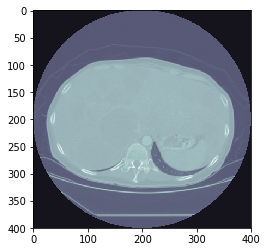

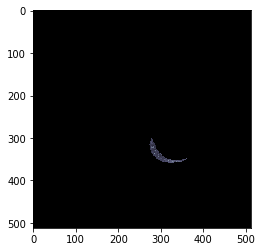

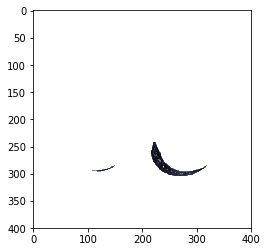

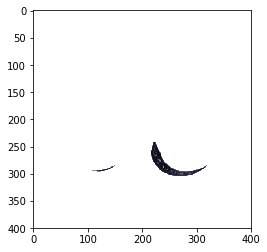

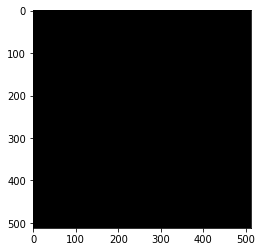

In [169]:
random_slice_index = int(np.random.random() * image.shape[0])
plot_2d(pix_resampled[random_slice_index])
plot_2d(lung_mask[random_slice_index])
plot_2d(np.multiply(pix_resampled[random_slice_index], segmented_lungs[random_slice_index]))
plot_2d(np.multiply(pix_resampled[random_slice_index], segmented_lungs_fill[random_slice_index]))

plot_2d(lung_nodule_mask[random_slice_index])